# Benchmarking of Graph Network

In [1]:
from copy import deepcopy
from matplotlib import pyplot as plt
from moleculekit.molecule import Molecule
from moleculekit.periodictable import periodictable
import numpy as np
import torch as pt
from torch.utils.benchmark import Timer
from torchmdnet.models.model import create_model
from torchmdnet.optimize import optimize as optimize_model

## Models

In [2]:
# Graph network (default)
model_1 = create_model({
    'embedding_dimension': 128,
    'num_layers': 6,
    'num_rbf': 50,
    'rbf_type': 'expnorm',
    'trainable_rbf': True,
    'activation': 'silu',
    'neighbor_embedding': True,
    'cutoff_lower': 0.0,
    'cutoff_upper': 5.0,
    'max_z': 100,
    'max_num_neighbors': 32,
    'model': 'graph-network',
    'aggr': 'add',
    'derivative': False,
    'atom_filter': -1,
    'prior_model': None,
    'output_model': 'Scalar',
    'reduce_op': 'add',
    'neighbors': 'simple'
})

# Graph network (compatible with NNPOps, https://github.com/torchmd/torchmd-net/issues/48),
# i.e. rbf_type='gauss', trainable_rbf=False, activation='ssp', and neighbor_embedding=False
model_2 = create_model({
    'embedding_dimension': 128,
    'num_layers': 6,
    'num_rbf': 50,
    'rbf_type': 'gauss',
    'trainable_rbf': False,
    'activation': 'ssp',
    'neighbor_embedding': False,
    'cutoff_lower': 0.0,
    'cutoff_upper': 5.0,
    'max_z': 100,
    'max_num_neighbors': 32,
    'model': 'graph-network',
    'aggr': 'add',
    'derivative': False,
    'atom_filter': -1,
    'prior_model': None,
    'output_model': 'Scalar',
    'reduce_op': 'add',
    'neighbors': 'simple'
})

# Graph network (brute force)
model_3 = create_model({
    'embedding_dimension': 128,
    'num_layers': 6,
    'num_rbf': 50,
    'rbf_type': 'expnorm',
    'trainable_rbf': True,
    'activation': 'silu',
    'neighbor_embedding': True,
    'cutoff_lower': 0.0,
    'cutoff_upper': 5.0,
    'max_z': 100,
    'max_num_neighbors': 32,
    'model': 'graph-network',
    'aggr': 'add',
    'derivative': False,
    'atom_filter': -1,
    'prior_model': None,
    'output_model': 'Scalar',
    'reduce_op': 'simple_add',
    'neighbors': 'brute_force'
})
# Graph network (optimized)
model_4 = create_model({
    'embedding_dimension': 128,
    'num_layers': 6,
    'num_rbf': 50,
    'rbf_type': 'expnorm',
    'trainable_rbf': True,
    'activation': 'silu',
    'neighbor_embedding': True,
    'cutoff_lower': 0.0,
    'cutoff_upper': 5.0,
    'max_z': 100,
    'max_num_neighbors': 32,
    'model': 'graph-network',
    'aggr': 'add',
    'derivative': False,
    'atom_filter': -1,
    'prior_model': None,
    'output_model': 'Scalar',
    'reduce_op': 'simple_add',
    'neighbors': 'optimized',
    'conv': 'optimized'
})

## Benchmarking function

In [3]:
def benchmark(model, pdb_file, device, optimize=True, compute_forces=True, compute_derivatives=False, batch_size=1, cuda_graph=False):

    # Optimize the model
    model = deepcopy(model).to(device)
    if optimize:
        assert not compute_derivatives
        assert batch_size == 1
        model = optimize_model(model)

    # Setup the derivative computation
    for parameter in model.parameters():
        parameter.requires_grad = compute_derivatives

    # Get molecular data
    molecule = Molecule(pdb_file)
    atomic_numbers = pt.tensor([periodictable[symbol].number for symbol in molecule.element], dtype=pt.long, device=device)
    positions = pt.tensor(molecule.coords[:,:,0], dtype=pt.float32, device=device).to(device)

    # Setup a batch
    batch = pt.flatten(pt.tile(pt.arange(batch_size).unsqueeze(1), (1, len(atomic_numbers)))).to(device)
    atomic_numbers = pt.tile(atomic_numbers, (batch_size,))
    positions = pt.tile(positions, (batch_size, 1)).detach()

    # Setup the force computation
    assert not (compute_forces and (batch_size > 1))
    positions.requires_grad = compute_forces

    # Setup a benchmark
    stmt = None
    graph = None
    if cuda_graph:

        # Create a graph
        graph = pt.cuda.CUDAGraph()

        # Warm up the graph
        for _ in range(3):
            energy =  model(atomic_numbers, positions, batch)[0]
            if compute_forces or compute_derivatives:
                energy.sum().backward()

        # Capture the grpah
        with pt.cuda.graph(graph):
            energy = model(atomic_numbers, positions, batch)[0]
            if compute_forces or compute_derivatives:
                energy.sum().backward()

        stmt = 'graph.replay()'
    else:
        stmt = f'''
            energy = model(atomic_numbers, positions, batch)
            {'energy[0].sum().backward()' if compute_forces or compute_derivatives else ''}
            '''

    # Benchmark
    timer = Timer(stmt=stmt, globals=locals())
    speed = timer.blocked_autorange(min_run_time=10).median * 1000 # s --> ms

    return speed

## Speed for MD

In [11]:
device = pt.device('cuda')
systems = [('systems/alanine_dipeptide.pdb', 'ALA2'),
           ('systems/testosterone.pdb', 'TST'),
           ('systems/chignolin.pdb', 'CLN'),
           ('systems/dhfr.pdb', 'DHFR'),
           ('systems/factorIX.pdb', 'FC9'),
           ('systems/stmv.pdb', 'STMV')]

methods = [('default', model_1, False, False),
           ('compatible', model_2, False, False),
           ('optimized', model_2, True, False),
           ('brute_force', model_3, False, False),
           ('brute_force+graph', model_3, False, True),
           ('kernels', model_4, False, False),
           ('kernels+graph', model_4, False, True)]

speed_methods = {}
for meth, model, optimize, cuda_graph in methods:
    speed_methods[meth] = {}
    print(f'Method: {meth}')
    for pdb_file, name in systems:
        if meth.startswith('kernels') and name == 'STMV':
            continue # Skip crashes
        try:
            speed = benchmark(model, pdb_file, device, optimize=optimize, compute_forces=True ,compute_derivatives=False, batch_size=1, cuda_graph=cuda_graph)
            speed_methods[meth][name] = speed
            print(f'  {name}: {speed} ms/it')
        except Exception as e:
            print(f'  {name}: failed')

Method: default
  ALA2: 7.757005250314251 ms/it
  TST: 5.570079595781863 ms/it
  CLN: 6.207469699438661 ms/it
  DHFR: 27.457748702727258 ms/it
  FC9: 65.65632007550448 ms/it
  STMV: failed
Method: compatible
  ALA2: 7.616091496311128 ms/it
  TST: 7.382718279841357 ms/it
  CLN: 7.9225919500458994 ms/it
  DHFR: 25.72089401073754 ms/it
  FC9: 62.19887896440923 ms/it
  STMV: failed
Method: optimized
  ALA2: 3.7700307997874916 ms/it
  TST: 2.6040034706238657 ms/it
  CLN: 2.9341555997962137 ms/it
  DHFR: 20.46170219546184 ms/it
  FC9: 47.44401149800978 ms/it
  STMV: 225.56804306805134 ms/it
Method: brute_force
  ALA2: 6.164753279881552 ms/it
  TST: 5.088040593545885 ms/it
  CLN: 8.753507304936647 ms/it
  DHFR: failed
  FC9: failed
  STMV: failed
Method: brute_force+graph
  ALA2: 1.1359305900987238 ms/it
  TST: 1.5810047095874324 ms/it
  CLN: 8.72353590093553 ms/it
  DHFR: failed
  FC9: failed
  STMV: failed
Method: kernels
  ALA2: 6.682521830080077 ms/it
  TST: 6.4234613557346165 ms/it
  CLN

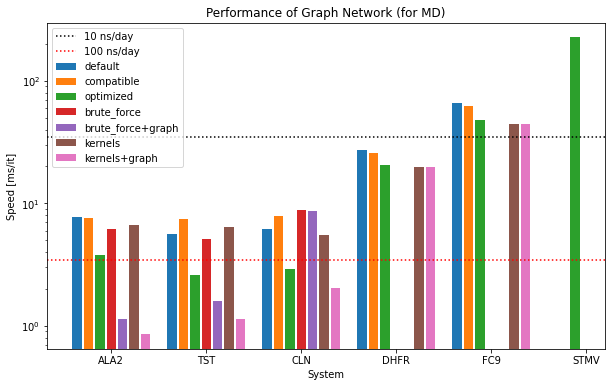

In [12]:
plt.figure(figsize=(10,6))

labels = []
for i, (meth, speeds) in enumerate(speed_methods.items()):
    labels = speeds.keys() if len(speeds.keys()) > len(labels) else labels
    x = np.arange(len(speeds)) + 0.12*i - 0.36
    plt.bar(x, speeds.values(), width=0.1, log=True, label=meth)

plt.axhline(34.56, color='black', linestyle=':', label='10 ns/day')
plt.axhline(3.456, color='red', linestyle=':', label='100 ns/day')
#plt.axhline(0.3456, color='green', linestyle=':', label='1 µs/day')

plt.title('Performance of Graph Network (for MD)')
plt.xlabel('System')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('Speed [ms/it]')
plt.legend()
plt.show()

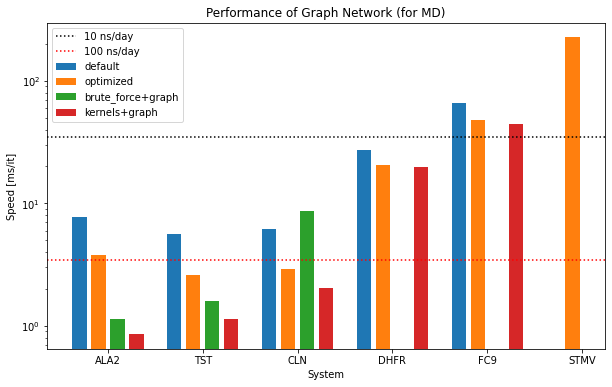

In [13]:
plt.figure(figsize=(10,6))

labels = []
for i, (meth, speeds) in enumerate(speed_methods.items()):
    if meth not in ['default', 'optimized', 'brute_force+graph', 'kernels+graph']:
        continue
    labels = speeds.keys() if len(speeds.keys()) > len(labels) else labels
    x = np.arange(len(speeds)) + 0.1*i - 0.3
    plt.bar(x, speeds.values(), width=0.15, log=True, label=meth)

plt.axhline(34.56, color='black', linestyle=':', label='10 ns/day')
plt.axhline(3.456, color='red', linestyle=':', label='100 ns/day')
#plt.axhline(0.3456, color='green', linestyle=':', label='1 µs/day')

plt.title('Performance of Graph Network (for MD)')
plt.xlabel('System')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('Speed [ms/it]')
plt.legend()
plt.show()

## Speed for inference and training

In [7]:
device = pt.device('cuda')
systems = [('systems/alanine_dipeptide.pdb', 'ALA2'),
           ('systems/chignolin.pdb', 'CLN'),
           ('systems/dhfr.pdb', 'DHFR'),
           ('systems/factorIX.pdb', 'FC9'),
           ('systems/stmv.pdb', 'STMV')]

speed_inference = {}
for pdb_file, name in systems:
    speed_inference[name] = {}
    print(f'System: {name}')
    for batch_size in (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024):
        try:
            speed = benchmark(model_1, pdb_file, device, optimize=False, compute_forces=False, compute_derivatives=False, batch_size=batch_size)
            speed_inference[name][batch_size] = speed
            print(f'  {batch_size}: {speed} ms/it')
        except Exception as e:
            print(f'  {batch_size}: failed')

System: ALA2
  1: 2.4861062492709607 ms/it
  2: 2.5061728397849947 ms/it
  4: 2.5388672697590664 ms/it
  8: 2.5920872192364186 ms/it
  16: 2.6188351097516716 ms/it
  32: 2.702325020218268 ms/it
  64: 4.208131875493564 ms/it
  128: 7.17243815306574 ms/it
  256: 13.039818801917136 ms/it
  512: 24.783973093144596 ms/it
  1024: 48.288187896832824 ms/it
System: CLN
  1: 2.6697896799305454 ms/it
  2: 2.6968458900228143 ms/it
  4: 3.723080400377512 ms/it
  8: 6.0869605804327875 ms/it
  16: 10.697794100269675 ms/it
  32: 20.035546290455386 ms/it
  64: 38.539564597886056 ms/it
  128: 75.95184003002942 ms/it
  256: 151.46871493197978 ms/it
  512: 302.27623804239556 ms/it
  1024: failed
System: DHFR
  1: 14.512782893143594 ms/it
  2: 24.166591750690714 ms/it
  4: 43.64813229767606 ms/it
  8: 82.24218455143273 ms/it
  16: 160.86132498458028 ms/it
  32: 321.35119393933564 ms/it
  64: failed
  128: failed
  256: failed
  512: failed
  1024: failed
System: FC9
  1: 37.302917102351785 ms/it
  2: 61.08

In [8]:
device = pt.device('cuda')
systems = [('systems/alanine_dipeptide.pdb', 'ALA2'),
           ('systems/chignolin.pdb', 'CLN'),
           ('systems/dhfr.pdb', 'DHFR'),
           ('systems/factorIX.pdb', 'FC9'),
           ('systems/stmv.pdb', 'STMV')]

speed_training = {}
for pdb_file, name in systems:
    speed_training[name] = {}
    print(f'System: {name}')
    for batch_size in (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024):
        try:
            speed = benchmark(model_1, pdb_file, device, optimize=False, compute_forces=False, compute_derivatives=True, batch_size=batch_size)
            speed_training[name][batch_size] = speed
            print(f'  {batch_size}: {speed} ms/it')
        except Exception as e:
            print(f'  {batch_size}: failed')

System: ALA2
  1: 5.114061804488301 ms/it
  2: 4.763865494169295 ms/it
  4: 4.815996304387227 ms/it
  8: 8.839142245124094 ms/it
  16: 8.955113898264244 ms/it
  32: 7.392882002750411 ms/it
  64: 11.198377649998294 ms/it
  128: 21.029278700007126 ms/it
  256: 35.71205519838258 ms/it
  512: 64.40078329760581 ms/it
  1024: 122.48519348213449 ms/it
System: CLN
  1: 5.429310502950102 ms/it
  2: 9.369305602740496 ms/it
  4: 10.109142796136439 ms/it
  8: 18.350619496777654 ms/it
  16: 29.842441499931738 ms/it
  32: 52.75012090569362 ms/it
  64: 98.44192810123786 ms/it
  128: 190.90869603678584 ms/it
  256: failed
  512: failed
  1024: failed
System: DHFR
  1: 34.02761734905653 ms/it
  2: 57.1388925309293 ms/it
  4: 103.85982901789248 ms/it
  8: failed
  16: failed
  32: failed
  64: failed
  128: failed
  256: failed
  512: failed
  1024: failed
System: FC9
  1: 74.90879448596388 ms/it
  2: 130.16938394866884 ms/it
  4: failed
  8: failed
  16: failed
  32: failed
  64: failed
  128: failed
 

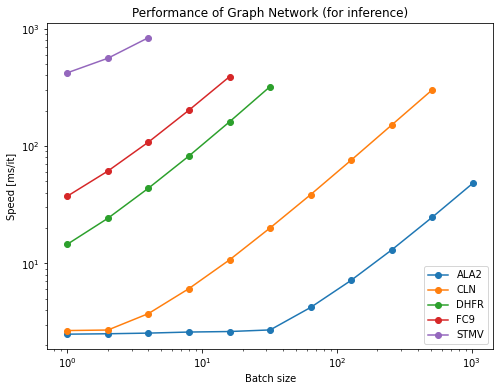

In [9]:
plt.figure(figsize=(8,6))

for name, speeds in speed_inference.items():
    plt.plot(speeds.keys(), speeds.values(), label=name, marker='o')

plt.title('Performance of Graph Network (for inference)')
plt.xlabel('Batch size')
plt.ylabel('Speed [ms/it]')
plt.loglog()
plt.legend()
plt.show()

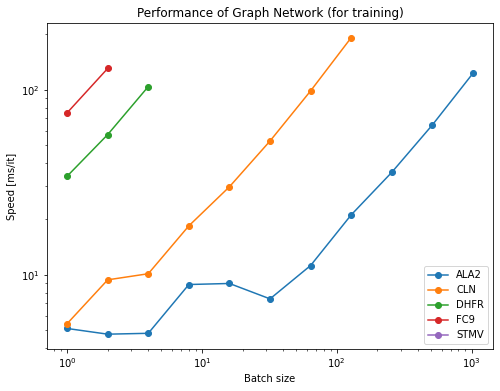

In [10]:
plt.figure(figsize=(8,6))

for name, speeds in speed_training.items():
    plt.plot(speeds.keys(), speeds.values(), label=name, marker='o')

plt.title('Performance of Graph Network (for training)')
plt.xlabel('Batch size')
plt.ylabel('Speed [ms/it]')
plt.loglog()
plt.legend()
plt.show()